# Housing Model - Multiple Factors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import random

In [2]:
# Parameters
lambda_ = 0.85  # lambda parameter for updating house values
n, m = 50, 50  # Grid size

# Define affluence values for rich, middle, and poor
affluence_levels = {
    "rich": 1.0,
    "middle": 0.5,
    "poor": 0.1
}

# Probabilities of rich, middle and poor
p = [0.1, 0.3, 0.6]

# Radius of square neighbourhood
r = 4

In [7]:
def random_board(n, m, p):
    """
    Initialize the grids with random affluence levels, house values, and religion.
    """
    # Initialize the affluence grid based on given probabilities
    affluence_grid = np.random.choice(
        [affluence_levels["rich"], affluence_levels["middle"], affluence_levels["poor"]],
        size=(n, m), p=p
    )
    
    # Initialize the house grid with zeros
    house_grid = np.zeros((n, m))  # All house values start as 0
    
    # Initialize the religion grid with binary values (1 or 0) with uniform distribution
    religion_grid = np.random.choice([1, 0], size=(n, m), p=[0.5, 0.5])

    # Initialize the political opinion grid with values (0, 0.5, 1) with some distribution
    politics_grid = np.random.choice([1, 0.5, 0], size=(n, m), p=[0.25, 0.25, 0.5])
    
    return affluence_grid, house_grid, religion_grid, politics_grid

In [8]:
def calculate_neighborhood_average(house_grid, x, y, r):
    """
    Calculate the weighted average house value in the square neighborhood of radius r around (x, y),
    with closer neighbours having more weight according to inverse square distance.
    """
    n, m = house_grid.shape    
    weighted_sum = 0
    total_weight = 0
    
    x_min, y_min = max(0, x - r), max(0, y - r)
    x_max, y_max = min(n, x + r + 1), min(m, y + r + 1)
    
    # Iterate over the neighborhood within the radius
    for i in range(x_min, x_max):
        for j in range(y_min, y_max):
            # Calculate the distance from (x, y)
            dx, dy = x - i, y - j
            distance_squared = dx**2 + dy**2
            
            # Avoid division by zero by setting a minimum distance
            if distance_squared == 0:
                weight = 1
            else:
                weight = 1 / distance_squared
            
            # Weighted sum and total weight
            weighted_sum += house_grid[i, j] * weight
            total_weight += weight

    # Calculate the weighted average of the neighborhood
    weighted_average = weighted_sum / total_weight
    return weighted_average

In [9]:
def update_values(affluence_grid, house_grid, lambda_):
    """
    Update house values based on the affluence and neighborhood average.
    """
    new_house_grid = np.zeros_like(house_grid)
    n, m = house_grid.shape
    for x in range(n):
        for y in range(m):
            affluence = affluence_grid[x, y]
            neighborhood_avg = calculate_neighborhood_average(house_grid, x, y, r)
            new_house_grid[x, y] = affluence + lambda_ * neighborhood_avg
    return new_house_grid

In [10]:
def propose_swap(affluence_grid, house_grid, religion_grid, politics_grid):
    """
    Calculate delta and swap agents if delta > 0.
    """
    n, m = house_grid.shape
    # Choose two random houses
    x1, y1 = random.randint(0, n-1), random.randint(0, m-1) # this will never choose n-1 or m-1 since randint is exclusive of upper bound
    x2, y2 = random.randint(0, n-1), random.randint(0, m-1)

    A_x1, A_x2 = affluence_grid[x1, y1], affluence_grid[x2, y2]
    V_x1, V_x2 = house_grid[x1, y1], house_grid[x2, y2]    
    delta_econ = (A_x1 - V_x1)**2 + (A_x2 - V_x2)**2 - (A_x1 - V_x2)**2 - (A_x2 - V_x1)**2

    R_x1, R_x2 = religion_grid[x1, y1], religion_grid[x2, y2]
    R_nbhd_x1, R_nbhd_x2 = calculate_neighborhood_average(religion_grid, x1, y1, r), calculate_neighborhood_average(religion_grid, x2, y2, r)
    delta_rel = (R_x1 - R_nbhd_x1)**2 + (R_x2 - R_nbhd_x2)**2 - (R_x1 - R_nbhd_x2)**2 - (R_x2 - R_nbhd_x1)**2
    
    P_x1, P_x2 = politics_grid[x1, y1], politics_grid[x2, y2]
    P_nbhd_x1, P_nbhd_x2 = calculate_neighborhood_average(politics_grid, x1, y1, r), calculate_neighborhood_average(politics_grid, x2, y2, r)
    delta_pol = (P_x1 - P_nbhd_x1)**2 + (P_x2 - P_nbhd_x2)**2 - (P_x1 - P_nbhd_x2)**2 - (P_x2 - P_nbhd_x1)**2 
    
    if delta_econ > 0 and 0.5 * delta_rel + 0.5 * delta_pol > 0:
        # Swap the two agents on all grids
        affluence_grid[x1, y1], affluence_grid[x2, y2] = A_x2, A_x1
        house_grid[x1, y1], house_grid[x2, y2] = V_x2, V_x1
        religion_grid[x1, y1], religion_grid[x2, y2] = R_x2, R_x1
        politics_grid[x1, y1], politics_grid[x2, y2] = P_x2, P_x1

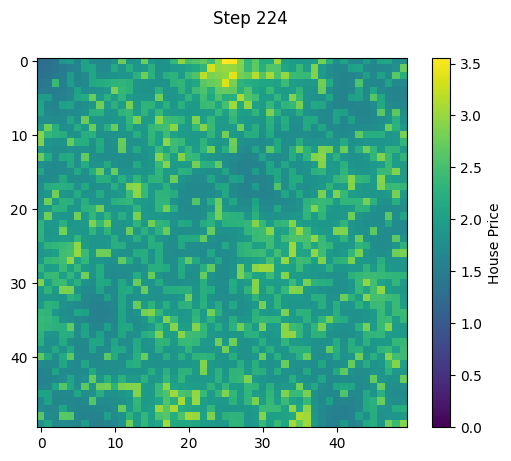

KeyboardInterrupt: 

In [12]:
# Simulation parameters
n_steps = 500
affluence_grid, house_grid, religion_grid, politics_grid = random_board(n, m, p)

fig, ax = plt.subplots()
fig.suptitle('Step 0')
img = plt.imshow(house_grid, cmap='viridis',vmin=0, vmax=3)

cbar = fig.colorbar(img, ax=ax)
cbar.set_label('House Price')


# Simulation loop
for step in range(n_steps):
    # Update house values
    house_grid = update_values(affluence_grid, house_grid, lambda_)

    # Propose random move - several in each step
    for i in range(100):
        propose_swap(affluence_grid, house_grid, religion_grid, politics_grid)

    img.set_array(house_grid)
    img.set_clim(vmax = np.max(house_grid))
    fig.suptitle(f"Step {step}")
    plt.pause(0.1)
    clear_output(wait=True)
    display(fig)

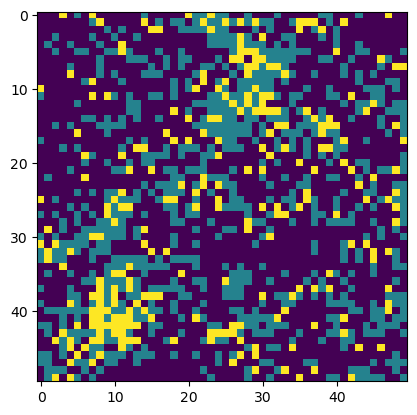

In [9]:
fig, ax = plt.subplots()
img = plt.imshow(affluence_grid, cmap='viridis')

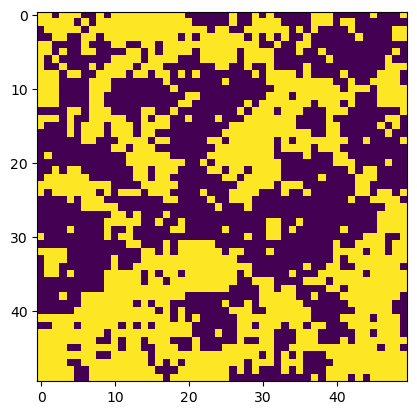

In [10]:
fig, ax = plt.subplots()
img = plt.imshow(religion_grid, cmap='viridis')

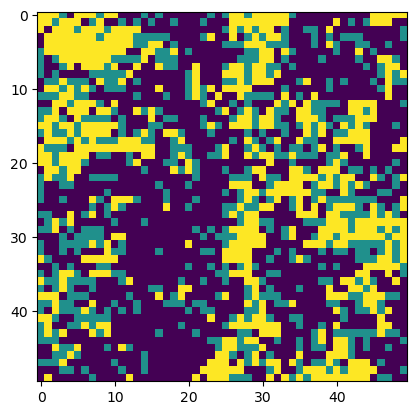

In [11]:
fig, ax = plt.subplots()
img = plt.imshow(politics_grid, cmap='viridis')